In [3]:
def find_points_in_tel_range(telra, teldec, ra, dec, radius = None):
    """Return a list of indices of points that are within a radius of an arbitrary telra, teldec.

    This function is optimized to query a lot of points with a single telra and teldec.

    radius is in units of degrees. The return value is a list
    that contains the index of points that are in each tile.
    The indices are not sorted in any particular order.

    if tiles is a scalar, a single list is returned.

    default radius is from desimodel.focalplane.get_tile_radius_deg()
    
    Note: This is simply a modified version of find_points_in_tiles, but this function does not know about tiles. 
    """
    from scipy.spatial import cKDTree as KDTree
    import desimodel.focalplane
    import numpy as np

    if radius is None:
        radius = desimodel.focalplane.get_tile_radius_deg()

    # check for malformed input shapes. Sorry we currently only
    # deal with vector inputs. (for a sensible definition of indices)

    assert ra.ndim == 1
    assert dec.ndim == 1

    points = _embed_sphere(ra, dec)
    tree = KDTree(points)

    # radius to 3d distance
    threshold = 2.0 * np.sin(np.radians(radius) * 0.5)
    xyz = _embed_sphere(telra, teldec)
    indices = tree.query_ball_point(xyz, threshold)
    return indices

def _embed_sphere(ra, dec):
    """ embed RA DEC to a uniform sphere in three-d """
    import numpy as np
    
    phi = np.radians(np.asarray(ra))
    theta = np.radians(90.0 - np.asarray(dec))
    r = np.sin(theta)
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    z = np.cos(theta)
    return np.array((x, y, z)).T

In [4]:
def on_gfa(telra, teldec, ra, dec, buffer_arcsec = 100):
    """
    Checks if a target is on any of the 10 GFAs given telra, teldec and an array of RA and Dec pointings,
    as well as a parameter for degrees of tolerance one would like to allow. When using 
    desimodel.footprint.find_points_in_tiles(tiles, ra, dec, radius) with this function to 
    check what points are on the GFAs, the default radius parameter should be set to 1.651 (degrees),
    so that boundary GFA area actually encompasses points normally outside of the tile. 
    Parameters:
    telra: The telescope's arbitrary RA pointing
    teldec: The telescope's arbitrary Dec pointing
    ra: An array of RA values for locations in the sky
    dec: An array of declination values for locations in the sky
    buffer_arcsec: A value in arcseconds on the sky of how much tolerance 
    one would allow for seeing if a target is on the gfa.  
    Returns: 
    targetindices: a list  of targets with their respective indices in the 
    RA and Dec list passed in that fall on certain GFAs denoted by the index 
    in the gfaindices list.
    gfaindices: a list equal in length with the targetindices list with the gfa location 0-9 as each element
    """
    import desimodel.footprint
    # If any calculated area is under the threshold area, it is mathematically impossible
    THRESHOLD_AREA = 469.7
    MIN_TOLERANCE = 0.001
    
    #inrangeindices = desimodel.footprint.find_points_in_tel_range(telra, teldec, ra, dec)
    inrangeindices = find_points_in_tel_range(telra, teldec, ra, dec, 1.651)
    if not inrangeindices:
        return [], []
    inrangeindices = np.asarray(inrangeindices)
    
    targetx, targety = desimodel.focalplane.radec2xy(telra, teldec, ra[inrangeindices], dec[inrangeindices])
    
    x_tolerance, y_tolerance = degrees2xytolerance(buffer_arcsec)
    
    targetindices = []
    gfaindices = []
    
    # x and y hold the 40 new GFA coordinates
    x, y = shift_gfa_points(x_tolerance, y_tolerance)
    # The area boundary's value is the area of the gfa plus some tolerance. 
    AREA_BOUNDARY = retrieve_minimum_boundary(x_tolerance, y_tolerance) + MIN_TOLERANCE
    
    targetx = np.asarray(targetx)
    targety = np.asarray(targety)
    # Method to check if point is inside the rectangle
    for gfaid in range(0, 40, 4):
        # a1 through a4 are edge lengths of the rectangle formed by corners of the GFAs
        a1 = np.sqrt((x[gfaid] - x[gfaid + 1])**2
                    + (y[gfaid] - y[gfaid + 1])**2)
        a2 = np.sqrt((x[gfaid + 1] - x[gfaid + 2])**2
                    + (y[gfaid + 1] - y[gfaid + 2])**2)
        a3 = np.sqrt((x[gfaid + 2] - x[gfaid + 3])**2
                    + (y[gfaid + 2] - y[gfaid + 3])**2)
        a4 = np.sqrt((x[gfaid + 3] - x[gfaid])**2
                    + (y[gfaid + 3] - y[gfaid])**2)
        # b1 through b4 are the line segments from each corner to the target location
        b1 = np.sqrt((x[gfaid] - targetx)**2
                    + (y[gfaid] - targety)**2)
        b2 = np.sqrt((x[gfaid + 1] - targetx)**2
                    + (y[gfaid + 1] - targety)**2)
        b3 = np.sqrt((x[gfaid + 2] - targetx)**2
                    + (y[gfaid + 2] - targety)**2)
        b4 = np.sqrt((x[gfaid + 3] - targetx)**2
                    + (y[gfaid + 3] - targety)**2)
        # Calculating areas of triangles using Heron's Formula
        u1 = (a1 + b1 + b2) / 2.0
        u2 = (a2 + b2 + b3) / 2.0
        u3 = (a3 + b3 + b4) / 2.0
        u4 = (a4 + b4 + b1) / 2.0
        area1 = np.sqrt((u1 * (u1 - a1) * (u1 - b1) * (u1 - b2)).clip(0))
        area2 = np.sqrt((u2 * (u2 - a2) * (u2 - b2) * (u2 - b3)).clip(0))
        area3 = np.sqrt((u3 * (u3 - a3) * (u3 - b3) * (u3 - b4)).clip(0))
        area4 = np.sqrt((u4 * (u4 - a4) * (u4 - b4) * (u4 - b1)).clip(0))
        targetarea = area1 + area2 + area3 + area4
        
        
        assert np.all(targetarea > THRESHOLD_AREA)
        
        if(any(targetarea < AREA_BOUNDARY) and all(targetarea > THRESHOLD_AREA)):
            newtargetindices = np.where(targetarea < AREA_BOUNDARY)
            targetindices.extend(newtargetindices[0])
            gfaindices.extend([int(gfaid / 4)] * len(newtargetindices[0]))
    return inrangeindices[targetindices], gfaindices

In [5]:
def retrieve_minimum_boundary(x_tolerance, y_tolerance):
    """
    Used as a helper function to the on_gfa function to find the minimum boundary
    area for a point to lie inside a certain GFA given an tolerance in x and y in mm
    Parameters:
    x_tolerance: tolerance in x in mm
    y_tolerance: tolerance in y in mm
    Returns: 
    targetarea: the minimum boundary area for the procedure to check if a point is inside the GFA
    """
    import desimodel.footprint
    import desimodel.focalplane
    
    targetx = 116.279135121
    targety = -372.885546514
    #6.644525362152656, -9.055425745149217 GUARANTEED TO BE IN GFA (RA, DEC)
    #x, y = desimodel.focalplane.radec2xy(7.11, -10.53, targetx, targety)
    # If any calculated area is under the threshold area, it is mathematically impossible
    THRESHOLD_AREA = 469.7
    MIN_TOLERANCE = 0.001
    # The area boundary's value is the area of the gfa plus some tolerance. 
    
    # x and y hold the 40 new GFA coordinates
    x, y = shift_gfa_points(x_tolerance, y_tolerance)
    
    targetx = np.asarray(targetx)
    targety = np.asarray(targety)
    # Method to check if point is inside the rectangle
    for gfaid in range(0, 4, 4):
        # a1 through a4 are edge lengths of the rectangle formed by corners of the GFAs
        a1 = np.sqrt((x[gfaid] - x[gfaid + 1])**2
                    + (y[gfaid] - y[gfaid + 1])**2)
        a2 = np.sqrt((x[gfaid + 1] - x[gfaid + 2])**2
                    + (y[gfaid + 1] - y[gfaid + 2])**2)
        a3 = np.sqrt((x[gfaid + 2] - x[gfaid + 3])**2
                    + (y[gfaid + 2] - y[gfaid + 3])**2)
        a4 = np.sqrt((x[gfaid + 3] - x[gfaid])**2
                    + (y[gfaid + 3] - y[gfaid])**2)
        # b1 through b4 are the line segments from each corner to the target location
        b1 = np.sqrt((x[gfaid] - targetx)**2
                    + (y[gfaid] - targety)**2)
        b2 = np.sqrt((x[gfaid + 1] - targetx)**2
                    + (y[gfaid + 1] - targety)**2)
        b3 = np.sqrt((x[gfaid + 2] - targetx)**2
                    + (y[gfaid + 2] - targety)**2)
        b4 = np.sqrt((x[gfaid + 3] - targetx)**2
                    + (y[gfaid + 3] - targety)**2)
        # Calculating areas of triangles using Heron's Formula
        u1 = (a1 + b1 + b2) / 2.0
        u2 = (a2 + b2 + b3) / 2.0
        u3 = (a3 + b3 + b4) / 2.0
        u4 = (a4 + b4 + b1) / 2.0
        area1 = np.sqrt(u1 * (u1 - a1) * (u1 - b1) * (u1 - b2))
        area2 = np.sqrt(u2 * (u2 - a2) * (u2 - b2) * (u2 - b3))
        area3 = np.sqrt(u3 * (u3 - a3) * (u3 - b3) * (u3 - b4))
        area4 = np.sqrt(u4 * (u4 - a4) * (u4 - b4) * (u4 - b1))
        targetarea = area1 + area2 + area3 + area4
        
        assert np.all(targetarea > THRESHOLD_AREA)
        return targetarea

In [6]:
def degrees2xytolerance(buffer_arcsec):
    """
    Used as a helper function to the on_gfa function to find the tolerance in x and y
    given a tolerance in arcseconds
    Parameters:
    buffer_arcsec: a tolerance in arcseconds for checking if a point is on the GFA
    Returns: 
    x_tolerance: tolerance in x in mm
    y_tolerance: tolerance in y in mm
    """
    # Uses the center of a given GFA from DESI-0530-v13 Excel Spreadsheet to find the tolerance 
    import desimodel.io
    import scipy.interpolate
    platescale = desimodel.io.load_platescale()
    fn = scipy.interpolate.interp1d(platescale['radius'], platescale['radial_platescale'], kind = 'quadratic')
    fn1 = scipy.interpolate.interp1d(platescale['radius'], platescale['az_platescale'], kind = 'quadratic')
    # Center of a given GFA from DESI-0530-v13 Excel Spreadsheet
    x = 333.738
    y = 217.766
    radius = np.sqrt(x**2 + y**2)
    # Platescales are in units of microns per arcsecond
    r_ps = fn(radius)
    az_ps = fn(radius)
    x_tolerance = buffer_arcsec / (10**3) * r_ps
    y_tolerance = buffer_arcsec / (10**3) * az_ps
    return x_tolerance, y_tolerance

In [7]:
def shift_gfa_points(deltax, deltay):
    """
    Used as a helper function to the on_gfa function to find the new 
    GFA locations after incorporating a tolerance in x and y
    Parameters:
    deltax: tolerance in x in mm
    deltay: tolerance in y in mm
    Returns: 
    Returns the 40 new GFA locations in x and y
    """
    import numpy as np
    x = [-125.10482863, -129.83038525, -159.04283509, -154.31646944]
    y = [-370.01790486, -384.56223777, -375.05643893, -360.51151824]
    point1 = [x[2], y[2]]
    point2 = [x[1], y[1]]
    vector1 = [(point2[0] - point1[0]), (point2[1] - point1[1])]
    vector2 = [1, 0]
    # Angle between vector1 and vector 2 using dot product
    angle = np.arccos((np.dot(vector1, vector2))/(np.sqrt((vector1[0]**2) + (vector1[1]**2))))
    
    shiftmat = np.zeros(shape=(2,2))
    shiftmat[0] = [np.cos(angle), -np.sin(angle)]
    shiftmat[1] = [np.sin(angle), np.cos(angle)]
    reverseshift= np.zeros(shape=(2,2))
    reverseshift[0] = [np.cos(angle), np.sin(angle)]
    reverseshift[1] = [-np.sin(angle), np.cos(angle)]
    
    # Shifts the initial coordinates to be parallel to the vector [1, 0]
    coord = np.zeros(shape=(2,1))
    oldxcoord = x
    oldycoord = y
    for i in range(4):
        coord[0] = oldxcoord[i]
        coord[1] = oldycoord[i]
        newcoord = np.matmul(shiftmat, coord)
        oldxcoord[i] = newcoord[0]
        oldycoord[i] = newcoord[1]
        if(i == 0 or i == 1):
            x[i] = newcoord[0] + deltax
        else:
            x[i] = newcoord[0] - deltax
        if(i == 1 or i == 2):
            y[i] = newcoord[1] - deltay
        else:
            y[i] = newcoord[1] + deltay
    oldxcoord = x
    oldycoord = y
    for i in range(4):
        coord[0] = oldxcoord[i]
        coord[1] = oldycoord[i]
        newcoord = np.matmul(reverseshift, coord)
        oldxcoord[i] = newcoord[0]
        oldycoord[i] = newcoord[1]
        x[i] = newcoord[0]
        y[i] = newcoord[1]
    
    rotatemat = np.zeros(shape=(2,2))
    rotatemat[0] = [np.cos(np.radians(36)), -np.sin(np.radians(36))]
    rotatemat[1] = [np.sin(np.radians(36)), np.cos(np.radians(36))]
    return find_new_gfa_coordinates(x, y, rotatemat)

def find_new_gfa_coordinates(x, y, rotatemat):
    """
    Used as a helper function to the on_gfa function to find the new
    GFA coordinates given a list of x coordinates, y coordinates, and a rotation matrix
    Parameters:
    x: a list of x coordinates for the GFAs
    y: a list of y coordinates for the GFAs
    rotatemat: a matrix for rotating the respective coordinates
    Returns: 
    x_all: a complete list of the 40 GFA x coordinates
    y_all: a complete list of the 40 GFA y coordinates
    """
    import numpy as np
    x_all = np.zeros(shape=(40,1))
    y_all = np.zeros(shape=(40,1))
    coord = np.zeros(shape=(2,1))
    gfacoord = np.zeros(shape=(4, 2))
    oldxcoord = x
    oldycoord = y
    counter = 0
    for j in range(10):
        for i in range(4):
            coord[0] = oldxcoord[i]
            coord[1] = oldycoord[i]
            newcoord = np.matmul(rotatemat, coord)
            oldxcoord[i] = newcoord[0]
            oldycoord[i] = newcoord[1]
            gfacoord[i] = [newcoord[0], newcoord[1]]
            x_all[counter] = newcoord[0]
            y_all[counter] = newcoord[1]
            counter += 1
    return x_all, y_all

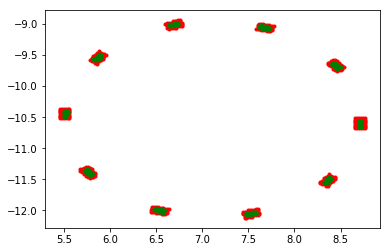

In [22]:
import matplotlib.pyplot as plt
import numpy as np
#telra and teldec = 7.11 -10.53
#tileid is 23658
mindec = -12.5
maxdec = -7
minra = 5.4
maxra = 8.9
ra = []
dec = []
import desimodel.focalplane
import desimodel.footprint
import desimodel.io
tiles = desimodel.io.load_tiles()

while mindec < maxdec:
    startra = minra
    while startra < maxra:
        ra.append(startra)
        dec.append(mindec)
        startra += .02
    mindec += .02

ra = np.asarray(ra)
dec = np.asarray(dec)

points = desimodel.footprint.find_points_in_tiles(tiles[8254], ra, dec, 1.651)

#plt.plot(ra[points], dec[points], 'b.')
targetindices, gfaindices = on_gfa(7.11, -10.53, ra, dec, 100)
plt.plot(ra[targetindices], dec[targetindices], 'r.')
targetindices, gfaindices = on_gfa(7.11, -10.53, ra, dec, 0)
plt.plot(ra[targetindices], dec[targetindices], 'g.')
plt.show()

In [9]:
def on_tile_gfa(tileid, targets, buffer_arcsec = 100):
    """
    This function takes a tileid, a table of targets, and an optional
    buffer_arcsec parameter to return the indices of targets lying on the GFA
    as well as the GFA locations from 0-9
    Parameters:
    tileid: (int) DESI tile ID, used to lookup telescope (RA, dec)
    targets: table with columns RA, DEC
    Options:
    buffer_arcsec: (float) additional buffer region around GFA to include
    Returns: 
    targetindices: list of indices for targets that are covered by GFA number 
    in corresponding gfaindices 
    gfaindices: list of indices corresponding to 0-9 GFA location
    """
    import desimodel.footprint
    telra, teldec = desimodel.footprint.get_tile_radec(tileid)
    return on_gfa(telra, teldec, targets['RA'], targets['DEC'], buffer_arcsec)

from astropy.io import fits
from astropy.table import Table
sweepname = 'sweep-280p050-290p055.fits'
sweep = Table.read(sweepname)
import desimodel.io
tiles = desimodel.io.load_tiles()
print(on_tile_gfa(23658, sweep, 120))

([], [])


In [19]:
def get_gfa_targets(targets, rfluxlim = 1000, tiles = None, buffer_arcsec = 100):
    """
    This function takes a table of targets, as well as optional parameters 
    including a minimum flux in the r-band, a list of tiles, and a buffer in arcseconds
    and returns a table of targets on the GFA satisfying a minimum flux_r
    Parameters
    ----------
    targets: table with columns RA, DEC, FLUX_R
    Options:
    rfluxlim: (float) r-band flux limit; default 1000 = rmag 15
    tiles: table of tiles, default to desimodel.io.load_tiles()
    buffer_arcsec: (float) additional buffer region around GFA to include
    Returns subset of input `targets` with additional columns:
    TILEID: (integer) DESI tile ID
    GFA_LOC: (integer) GFA location [0-9]
    Note that the same target could be repeated with different TILEID, GFA_LOC
    """
    if(tiles is None):
        import desimodel.io
        tiles = desimodel.io.load_tiles()
    import desimodel.footprint
    points = desimodel.footprint.find_points_in_tiles(tiles, targets['RA'], targets['DEC'])
    alltargetindices = []
    tileidlist = []
    gfaidlist = []
    # Checks if the flux_r meets a minimum threshold
    brightindices = np.where(targets['FLUX_R'] > rfluxlim)
    #print(brightindices)
    #print(len(brightindices))
    if(len(brightindices[0]) == 0):
        return np.array([])
    counter = 0
    for lists in points:
        if lists:
            tileid = tiles[counter]['TILEID']
            targetindices, gfaindices = on_tile_gfa(tileid, targets[brightindices[0]], buffer_arcsec)
            tileidlist.extend([tileid] * len(targetindices))
            alltargetindices.extend(targetindices)
            gfaidlist.extend(gfaindices)
        counter += 1
    validtargets = targets[brightindices[0]][alltargetindices]
    tileidlist = np.asarray(tileidlist)
    gfaidlist = np.asarray(gfaidlist)
    validtargets['TILEID'] = tileidlist
    validtargets['GFA_LOC'] = gfaidlist
    return validtargets
from astropy.io import fits
from astropy.table import Table
sweepname = 'sweep-280p050-290p055.fits'
sweep = Table.read(sweepname)

import desimodel.io
tiles = desimodel.io.load_tiles()
valid = get_gfa_targets(sweep)  
print(valid)

    

RELEASE BRICKID BRICKNAME OBJID ... SHAPEEXP_E2 SHAPEEXP_E2_IVAR TILEID GFA_LOC
------- ------- --------- ----- ... ----------- ---------------- ------ -------
   4000  585540  2814p502   398 ...         0.0              0.0   2199       8
   4000  584615  2816p500  3947 ...         0.0              0.0   2199       8
   4000  584615  2816p500  4206 ...         0.0              0.0   2199       8
   4000  584615  2816p500  4447 ...         0.0              0.0   2199       8
   4000  584615  2816p500  3687 ...         0.0              0.0   2199       8
   4000  584615  2816p500  4046 ...    0.127714          9212.78   2199       8
   4000  584615  2816p500  4047 ...  -0.0190994      1.01114e+06   2199       8
   4000  585540  2814p502   563 ...         0.0              0.0   2199       8
   4000  587373  2802p507  1302 ...         0.0              0.0   2199       9
   4000  587373  2802p507  1368 ...         0.0              0.0   2199       9
    ...     ...       ...   ... ...     

In [21]:
tiles = np.zeros((4,), dtype=[('TILEID', 'i2'), ('RA', 'f8'), ('DEC', 'f8'), ('FLUX_R', 'f8')])
tiles['TILEID'] = np.array([23658] * 4)
tiles['RA'] = [0.0, 1.0, 2.0, 3.0]
tiles['DEC'] = [-2.0, -1.0, 1.0, 2.0]
tiles['FLUX_R'] = [50, 50, 50, 100]
targets = get_gfa_targets(tiles)
print(targets)
print(targets.dtype.names)


[]
None


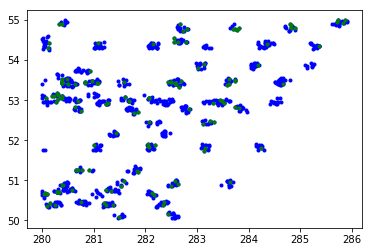

In [46]:
def plot_gfa_targets(targets, rfluxlim = 1000, rfluxmax = 10000, tiles = None, buffer_arcsec = 100, tileid = None):
    """
    This function takes a table of targets, as well as optional parameters 
    including a minimum flux in the r-band, a list of tiles, a buffer in arcseconds, 
    and a tileid number and uses blue to plot the targets on the GFA satisfying a minimum flux_r
    on either a specific tileid in the targets table, or all the targets on any tileid returned 
    by get_gfa_targets. It also uses red to plot all targets on the GFA above a maximum flux_r.
    Parameters:
    targets: table with columns RA, DEC, FLUX_R
    Options:
    rfluxlim: (float) r-band flux limit; default 1000 = rmag 15
    rfluxmax: (float) r-band flux maximum; default 5000
    tiles: table of tiles, default to desimodel.io.load_tiles()
    buffer_arcsec: (float) additional buffer region around GFA to include
    tileid: (int) a unique indentifier for a tile pointing
    """
    import matplotlib.pyplot as plt
    if(tiles is None):
        import desimodel.io
        tiles = desimodel.io.load_tiles()
    valid = get_gfa_targets(targets, rfluxlim, tiles, buffer_arcsec)
    if(tileid is None):
        plt.plot(valid['RA'], valid['DEC'], 'b.')
        brightindices = np.where(valid['FLUX_R'] > rfluxmax)
        plt.plot(valid[brightindices[0]]['RA'], valid[brightindices[0]]['DEC'], 'r.')
    else:    
        indices = np.where(valid['TILEID'] == tileid)
        plt.plot(valid[indices]['RA'], valid[indices]['DEC'], 'b.')
        brightindices = np.where(valid[indices]['FLUX_R'] > rfluxmax)
        plt.plot(valid[indices][brightindices[0]]['RA'], valid[indices][brightindices[0]]['DEC'], 'r.')
    plt.show()
    
from astropy.io import fits
from astropy.table import Table
sweepname = 'sweep-280p050-290p055.fits'
sweep = Table.read(sweepname)

plot_gfa_targets(sweep, tileid = None)
